In [1]:
# PERMANENT: Leave as is.  
# Purpose: Sets up mplsoccer Pitch styling and helper functions.  
# You must always run this cell once at the start of a session.

from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# ---------- STYLE (edit here to re-skin) ----------
STYLE = {
    "pitch": {"line_color": "black", "figsize": (10, 6.7)},
    "label": {"fontsize": 9, "dx": 1.2, "dy": 1.2, "color": "dimgray"},

    # Passes
    "pass_line":         {"color": "black", "linewidth": 2.0, "linestyle": "-"},
    "pass_recv_marker":  {"s": 120, "facecolor": "none", "edgecolor": "black", "linewidths": 1.8},

    # Aerial passes (dotted)
    "aerial_line":       {"color": "black", "linewidth": 2.0, "linestyle": (0, (1, 3))},
    "aerial_recv_marker":{"s": 120, "facecolor": "none", "edgecolor": "black", "linewidths": 1.8},

    # Dribbles / carries (blue dashed)
    "dribble_line":      {"color": "#1f77b4", "linewidth": 2.0, "linestyle": (0, (6, 4))},
    "dribble_end_marker":{"s": 120, "facecolor": "none", "edgecolor": "#1f77b4", "linewidths": 1.8},

    # Interceptions (red line, red X)
    "intercept_line":    {"color": "#d62728", "linewidth": 2.0, "linestyle": "-"},
    "intercept_marker":  {"c": "#d62728", "s": 140, "marker": "x", "linewidths": 2.0},

    # Shots (green triangle)
    "shot_marker":       {"c": "#2ca02c", "s": 150, "marker": "^"},
}

# ---------- Helpers ----------
def _draw_line(pitch, ax, x, y, x2, y2, *, color, linewidth, linestyle, zorder=3):
    pitch.lines(x, y, x2, y2, ax=ax, color=color, lw=linewidth,
                linestyle=linestyle, zorder=zorder)

def _label(ax, x, y, text, *, dx, dy, color, fontsize, zorder=5):
    if text is not None:
        ax.text(x + dx, y + dy, str(text), fontsize=fontsize,
                color=color, zorder=zorder)

# ---------- Main function ----------
def plot_chain(
    events,
    title="",
    style=None,
    annotate_numbers=True,
    show_legend=False,     # keep legend off by default per your preference
    final_triangle=True
):
    style = style or (globals().get("STYLE", {}) or {})
    pitch_conf    = style.get("pitch", {})
    pass_line     = style.get("pass_line", {"linewidth": 2.0, "linestyle": "-"})
    aerial_line   = style.get("aerial_line", {"linewidth": 2.0, "linestyle": (0,(1,3))})
    dribble_line  = style.get("dribble_line", {"linewidth": 2.0, "linestyle": (0,(6,4))})
    intercept_line= style.get("intercept_line", {"linewidth": 2.0, "linestyle": "-"})
    recv_marker   = style.get("pass_recv_marker", {"s": 120, "edgecolor": "black", "facecolor": "none"})
    shot_marker   = style.get("shot_marker", {"c":"#2ca02c","s":150,"marker":"^"})
    label_conf    = style.get("label", {"fontsize": 9, "dx": 1.2, "dy": 1.2, "color": "dimgray"})

    pitch = Pitch(line_color=pitch_conf.get("line_color", "black"))
    fig, ax = pitch.draw(figsize=pitch_conf.get("figsize", (10, 6.7)))
    if title:
        ax.set_title(title)

    def _style_for(etype: str):
        et = (etype or "pass").lower()
        if et == "dribble":     return dribble_line
        if et == "aerial":      return aerial_line
        if et == "intercepted": return intercept_line
        return pass_line

    def _arrow(ax, xs, ys, lw=2.0, ls="-", color="black", z=3):
        # Draws a polyline with a small arrowhead at the end (last segment)
        # xs, ys are arrays like [x1, r1x, r2x, ..., x2]
        # Draw the polyline first (without arrowhead) to keep aesthetics clean
        ax.plot(xs[:-1], ys[:-1], linestyle=ls, linewidth=lw, color=color, zorder=z)
        # Arrowhead only on the final tiny segment for crisp head
        patch = FancyArrowPatch((xs[-2], ys[-2]), (xs[-1], ys[-1]),
                                arrowstyle="-|>", mutation_scale=10,
                                linewidth=lw, linestyle=ls, color=color, zorder=z)
        ax.add_patch(patch)

    n = len(events)
    if n == 0:
        return fig, ax

    # --- Mark the very first anchor (start of segment 1) with a circle
    first = events[0]
    x1, y1 = first["x"], first["y"]
    ax.scatter([x1], [y1],
               s=recv_marker.get("s",120),
               facecolor=recv_marker.get("facecolor","none"),
               edgecolor=recv_marker.get("edgecolor","black"),
               linewidth=recv_marker.get("linewidths",1.25),
               zorder=4)

    for i, ev in enumerate(events):
        etype = str(ev.get("type", "pass")).lower()
        x1, y1 = ev["x"], ev["y"]
        x2, y2 = ev.get("x2"), ev.get("y2")
        route  = ev.get("route") or []   # optional list of (x,y) waypoints

        # Handle single-point events (starter anchors), rare in your flow
        if (x2 is None) or (y2 is None):
            # draw just a shot anchor if you ever pass one in
            ax.scatter([x1], [y1],
                       c=shot_marker.get("c","#2ca02c"),
                       s=shot_marker.get("s",150),
                       marker=shot_marker.get("marker","^"),
                       zorder=5)
            continue

        # Build the polyline path through any route waypoints (no markers on route)
        xs = [x1] + [p[0] for p in route] + [x2]
        ys = [y1] + [p[1] for p in route] + [y2]

        st = _style_for(etype)
        _arrow(ax, xs, ys,
               lw=st.get("linewidth", 2.0),
               ls=st.get("linestyle", "-"),
               color=st.get("color", "black"),
               z=3)

        # --- Endpoint markers:
        # Start anchor markers:
        #  - We already drew the *first* start anchor before the loop.
        #  - For subsequent segments, we DON'T redraw the start marker here
        #    to avoid double-marking and to let the previous segment's end marker
        #    control the visual (circle or X).
        if i == 0:
            pass  # already marked above

        # End anchor marker:
        is_last = (i == n - 1)
        if is_last and final_triangle:
            # final buildup ends at the shot -> green triangle
            ax.scatter([x2], [y2],
                       c=shot_marker.get("c","#2ca02c"),
                       s=shot_marker.get("s",150),
                       marker=shot_marker.get("marker","^"),
                       zorder=5)
        else:
            if etype == "intercepted":
                # X marker for intercepted ends
                ax.scatter([x2], [y2],
                           marker="x",
                           c="black",
                           s=max(recv_marker.get("s",120), 120),
                           linewidths=1.5,
                           zorder=5)
            else:
                # circle marker for normal ends
                ax.scatter([x2], [y2],
                           s=recv_marker.get("s",120),
                           facecolor=recv_marker.get("facecolor","none"),
                           edgecolor=recv_marker.get("edgecolor","black"),
                           linewidth=recv_marker.get("linewidths",1.25),
                           zorder=5)

        # Jersey number at the END of each segment (if provided)
        if annotate_numbers:
            num = ev.get("number")
            if num not in (None, "", "None"):
                dx = label_conf.get("dx", 1.2); dy = label_conf.get("dy", 1.2)
                ax.text(x2 + dx, y2 + dy, str(num),
                        fontsize=label_conf.get("fontsize", 9),
                        color=label_conf.get("color", "dimgray"),
                        zorder=6)

    return fig, ax

In [2]:
# PERMANENT: Leave as is.
# Purpose: Enables interactive matplotlib plots inside Jupyter.
# Required for clicking on the pitch (event capture).
# Run once at the start of the session, before using interactive tools.
%matplotlib widget

In [3]:
# EDIT-NEEDED: Batch starter plots + skeleton JSON for one match
# Purpose:
#   - Read the Understat CSV for ONE match.
#   - Filter shots by xG threshold (default 0.3).
#   - For each qualifying shot: save a PNG with the shot marker and a skeleton JSON
# Change the following data below before running:
#   - CSV_PATH (point to the match CSV)
#   - Optional: XG_CUTOFF (e.g., 0.30 -> 0.25)
#   - Optional: OUTPUT_DIR (where PNG/JSON go)

import pandas as pd
import json
import os


# -------- SETTINGS --------
CSV_PATH = "data/raw/understat_shots_match_28778.csv"
OUTPUT_DIR = "outputs"
XG_CUTOFF = 0.30  # change if you want a different threshold
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Understat CSV
df = pd.read_csv(CSV_PATH)

# Filter for shots with xG ≥ 0.3
shots = df[df["xG"] >= 0.3].reset_index(drop=True)

print(f"Found {len(shots)} shots with xG ≥ 0.3")

# Loop through shots and make starter plots
for i, row in shots.iterrows():
    shot_id = f"shot_{i+1}_{int(row['minute'])}"
    
    # Convert understat (0–1) coords to mplsoccer (0–100)
    x, y = row["x"] * 100, (1 - row["y"]) * 100
    
    # Build minimal event list (just the shot)
    events = [{
        "type": "shot",
        "x": x,
        "y": y,
        "player": row["player"],
        "team_attacking": row["team"],
        "xG": row["xG"],
        "minute": row["minute"],
        "result": row["result"],
        "situation": row["situation"],
        "shotType": row["shotType"],
    }]
    
    # Plot starter viz
    fig, ax = plot_chain(events, title=f"{row['team']} - {row['player']} (xG {row['xG']:.2f})")
    fig.savefig(os.path.join(OUTPUT_DIR, f"{shot_id}.png"), dpi=120)
    plt.close(fig)
    
    # Save skeleton JSON (with empty events list for you to fill later)
    chain_meta = {
        "match_meta": {
            "team_attacking": row["team"],
            "team_defending": "TBD",   # you’ll fill later
            "minute": row["minute"],
            "xG": row["xG"],
            "player": row["player"],
            "result": row["result"],
            "situation": row["situation"],
            "shotType": row["shotType"],
        },
        "events": []  # will fill later
    }
    
    with open(os.path.join(OUTPUT_DIR, f"{shot_id}.json"), "w") as f:
        json.dump(chain_meta, f, indent=2)

Found 5 shots with xG ≥ 0.3


In [ ]:
# OPTIONAL: Debugging / Verification
# Purpose: Lists all files in the outputs/ directory.
# Use this after running Cell 12 to confirm PNGs and JSONs were created.
import os, glob
print(os.getcwd())
print("outputs/ exists:", os.path.isdir("outputs"))
print("files in outputs/:")
for p in sorted(glob.glob("outputs/*")):
    print(" -", p)

In [4]:
# Shot Picker: choose which Understat chance (JSON) to annotate
# Place this cell ABOVE Cell 4 and run it before clicking on the pitch.

import os, re, json, glob
import pandas as pd
from ipywidgets import Dropdown, Button, VBox, HTML
from IPython.display import display, clear_output

OUTPUT_DIR = "outputs"

def _num_key(p):
    m = re.search(r"shot_(\d+)\.json$", p)
    return int(m.group(1)) if m else 0

files = sorted(glob.glob(os.path.join(OUTPUT_DIR, "shot_*.json")), key=_num_key)
if not files:
    display(HTML("<b>No shot_*.json files found in outputs/. Run Cell 3 first.</b>"))
else:
    # Build labels from match_meta for a nicer picker
    options = []
    for p in files:
        try:
            with open(p, "r") as f:
                data = json.load(f)
            mm = data.get("match_meta", {}) or {}
            minute = mm.get("minute", "?")
            team   = mm.get("team") or mm.get("team_attacking") or "Team"
            player = mm.get("player", "?")
            xg     = mm.get("xG", "?")
            result = mm.get("result", "")
            label = f"{os.path.basename(p)}  —  {minute}'  {team}  |  {player}  |  xG {xg}  |  {result}"
            options.append((label, p))
        except Exception:
            options.append((os.path.basename(p), p))

    dd = Dropdown(options=options, description="Shot:", layout={"width":"90%"})
    go = Button(description="Use this shot", button_style="success")
    out = HTML("")

    def choose(_):
        global SHOT_JSON
        SHOT_JSON = dd.value  # sets the variable used by Cells 4–6
        out.value = f"✓ <code>SHOT_JSON</code> set to <code>{SHOT_JSON}</code>."
    go.on_click(choose)

    display(VBox([dd, go, out]))

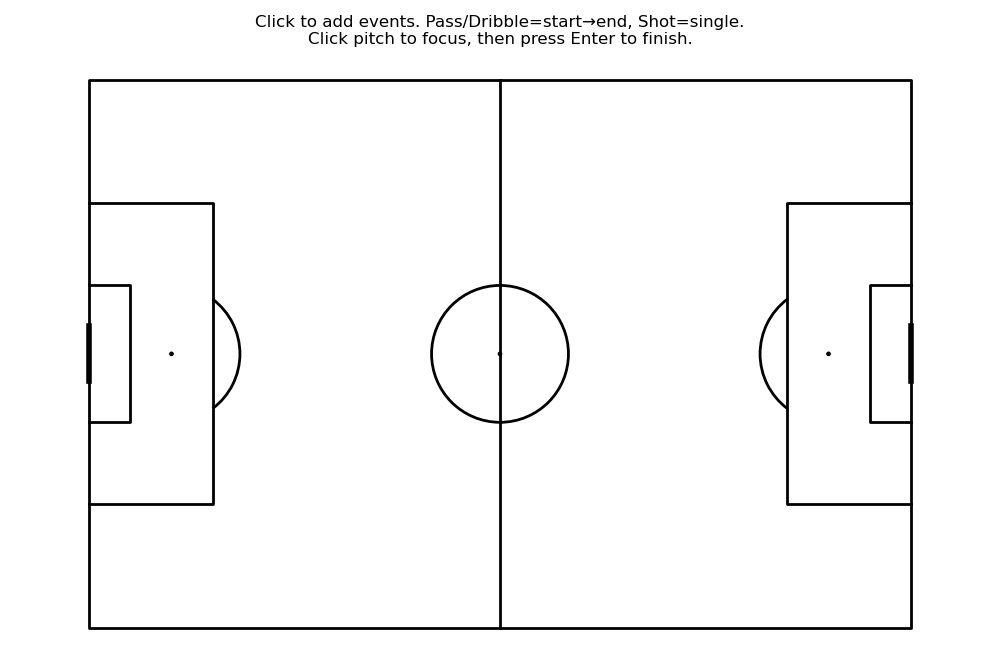

In [7]:
# EDIT-NEEDED: Interactive event capture for one shot.
# Purpose:
#   - Load a shot JSON file (SHOT_JSON) to place the green triangle anchor.
#   - Lets you click on the pitch to add events (red = passes/dribbles, etc.).
#   - Use Finish button or press Enter to stop; outputs clicked coordinates.
# Change here each time:
#   - SHOT_JSON = "outputs/shot_1.json" → update this to the shot JSON you want to annotate.
# Notes:
#   - Run this cell after generating outputs/*.json and outputs/*.png for a match.
#   - Use the printed clicked_points to copy/paste into the JSON "events" list.

import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from ipywidgets import Button as WButton, HBox, VBox, Output, HTML
from math import isnan

# ---- pick which shot (anchor marker) ----
SHOT_JSON = "outputs/shot_1.json"   # change as needed

# ---- load shot (if present in JSON 'events') ----
anchor = None
try:
    with open(SHOT_JSON, "r") as f:
        chain = json.load(f)
    for e in chain.get("events", []):
        if e.get("type") == "shot":
            anchor = (float(e["x"]), float(e["y"]))
            break
except Exception:
    pass

# ---- drawing ----
pitch = Pitch(line_color="black")
fig, ax = pitch.draw(figsize=(10, 6.7))
ax.set_title("Click to add events. Pass/Dribble=start→end, Shot=single.\nClick pitch to focus, then press Enter to finish.")

# anchor (green triangle) if present
if anchor:
    ax.scatter([anchor[0]], [anchor[1]], s=150, marker="^", c="#2ca02c", zorder=5)

clicked_points = []
out = Output()

# anchor (green triangle) if present ... (keep your existing anchor-loading code)

clicked_points = []    # left-click anchors
routes = []            # per-segment list of right-click waypoints; routes[i] applies to segment i: clicked_points[i] -> clicked_points[i+1]
current_route = []     # accumulates right-clicks until the next left-click ends the segment

out = Output()

def on_click(event):
    if event.inaxes is not ax or event.xdata is None or event.ydata is None:
        return
    x, y = float(event.xdata), float(event.ydata)

    # LEFT CLICK = anchor; RIGHT CLICK = route waypoint
    # Matplotlib: 1=left, 3=right; (2=middle)
    if event.button == 1:  # LEFT
        # draw an anchor dot
        ax.scatter([x], [y], s=60, c="red", zorder=6)
        fig.canvas.draw_idle()

        # store anchor
        clicked_points.append((x, y))

        # if this is NOT the first anchor, close out the previous segment's route
        if len(clicked_points) > 1:
            routes.append(current_route)
            current_route = []  # start a fresh route for the next segment

        # if this IS the first anchor, ensure current_route is fresh
        if len(clicked_points) == 1:
            current_route.clear()

    elif event.button == 3:  # RIGHT
        # route waypoint: do NOT draw a circle; just remember the path
        current_route.append((x, y))
        # Optionally show a faint guide line to last anchor just for user feedback (no markers)
        if clicked_points:
            x0, y0 = clicked_points[-1]
            xs = [x0] + [p[0] for p in current_route]
            ys = [y0] + [p[1] for p in current_route]
            ax.plot(xs, ys, linestyle=":", linewidth=1.0, color="black", zorder=2)
            fig.canvas.draw_idle()

cid_click = fig.canvas.mpl_connect("button_press_event", on_click)

def on_key(event):
    if event.key in ("enter", "return"):
        finish(None)
cid_key = fig.canvas.mpl_connect("key_press_event", on_key)

def finish(_):
    # disconnect
    try:
        fig.canvas.mpl_disconnect(cid_click)
        fig.canvas.mpl_disconnect(cid_key)
    except Exception:
        pass

    with out:
        print("clicked_points = [")
        for (x, y) in clicked_points:
            print(f"    ({x:.1f}, {y:.1f}),")
        print("]")

        # If at finish we have an unclosed route (after the last anchor), keep it for the final segment -> shot
        pending = current_route[:]  # copy
        if pending:
            print("\nroutes = [  # waypoints per segment (between consecutive anchors); last list is used for final segment to shot")
        else:
            print("\nroutes = [")
        # print routes for segments formed between anchors
        for r in routes:
            print("    [", end="")
            print(", ".join(f"({rx:.1f}, {ry:.1f})" for rx, ry in r), end="")
            print("],")
        # print pending route for the final segment-to-shot
        print("    [", end="")
        print(", ".join(f"({rx:.1f}, {ry:.1f})" for rx, ry in pending), end="")
        print("],")
        print("]")

finish_btn = WButton(description="Finish (widget)")
finish_btn.on_click(finish)

display(VBox([
    HTML("<b>Tip:</b> LEFT = anchor, RIGHT = route. Click pitch to focus, then press <b>Enter</b> to finish."),
    finish_btn, out
]))
plt.show()

In [8]:
# PERMANENT: Leave as is.
# Purpose: Build and save the full event chain from clicked_points.
# - Connects all left-click anchors sequentially.
# - Appends a final segment from your LAST click to the Understat shot location.
# - Saves JSON, shows a quick review table, renders & saves PNG.
#
# When to run:
# - Run this immediately AFTER you finish clicking on the pitch (Cell 4).

import os, json
import pandas as pd

# --- Load Understat shot anchor (from JSON skeleton saved earlier) ---
with open(SHOT_JSON, "r") as f:
    chain = json.load(f)

shot_meta = chain.get("match_meta", {}) or {}

# Infer pitch scale from your clicks (works for 0–100 or 0–120 by 0–80)
xs = [p[0] for p in clicked_points]
ys = [p[1] for p in clicked_points]
scale_x = 120.0 if max(xs) > 100 else 100.0
scale_y = 80.0  if max(ys) > 67  else 100.0

sx = shot_meta.get("x", 50.0)
sy = shot_meta.get("y", 50.0)

# If Understat is 0–1, scale to your pitch; if it’s already scaled, keep as-is
shot_x = float(sx) * scale_x if 0.0 <= float(sx) <= 1.0 else float(sx)
shot_y = float(sy) * scale_y if 0.0 <= float(sy) <= 1.0 else float(sy)

# --- Build events from clicked points (sequential) ---
events = []
# routes may be defined by Cell 4 (right-click waypoints). If not, fallback safely.
try:
    routes
except NameError:
    routes = []

def _route_for(idx):
    """
    Return route waypoints for segment index:
      0..(len(clicked_points)-2)  -> between anchors
      -1                          -> last segment from last anchor to shot
    """
    if 0 <= idx < len(routes):
        return routes[idx]
    if idx == -1 and routes:
        return routes[-1]
    return []
for i in range(len(clicked_points) - 1):
    (x1, y1) = clicked_points[i]
    (x2, y2) = clicked_points[i + 1]
    events.append({
    "type": "pass",   # placeholder; you relabel later
    "x": x1, "y": y1,
    "x2": x2, "y2": y2,
    "route": _route_for(i),   # NEW: carry any right-click waypoints for this segment
    "number": None,
    "player": None,
})

# Final segment: last click -> Understat shot location
x_last, y_last = clicked_points[-1]
events.append({
    "type": "pass",   # placeholder; you can relabel later
    "x": x_last, "y": y_last,
    "x2": shot_x, "y2": shot_y,
    "route": _route_for(-1),  # NEW: waypoints after last anchor (if any)
    "number": None,
    "player": shot_meta.get("player"),
    "xG": shot_meta.get("xG"),
    "result": shot_meta.get("result"),
    "situation": shot_meta.get("situation"),
    "shotType": shot_meta.get("shotType"),
})
# --- Save JSON ---
chain_out = {"match_meta": shot_meta, "events": events}
with open(SHOT_JSON, "w") as f:
    json.dump(chain_out, f, indent=2)
print(f"✓ Updated chain saved to {SHOT_JSON}")

# --- Review table ---
rows = [{
    "type": ev["type"],
    "x": round(ev["x"], 1),
    "y": round(ev["y"], 1),
    "x2": round(ev["x2"], 1),
    "y2": round(ev["y2"], 1),
    "player": ev.get("player"),
} for ev in events]
events_df = pd.DataFrame(rows)
display(events_df)

# --- Render & save PNG ---
team_for_title = shot_meta.get("team_attacking") or shot_meta.get("team") or "Team"
title = f"{team_for_title} - {shot_meta.get('player','?')} (xG {shot_meta.get('xG','?')})"
fig, ax = plot_chain(events, title=title)

png_out = os.path.splitext(SHOT_JSON)[0] + "_chain.png"
fig.savefig(png_out, dpi=150, bbox_inches="tight")
plt.close(fig)
print(f"✓ Visualization saved to {png_out}")

✓ Updated chain saved to outputs/shot_1.json


,type,x,y,x2,y2,player
0,pass,80.6,22.3,68.9,47.7,None
1,pass,68.9,47.7,50.0,50.0,Hugo Ekitike


✓ Visualization saved to outputs/shot_1_chain.png


In [ ]:
# PERMANENT: Leave as is.
# Purpose: Label each segment (type + jersey number), save JSON, and re-render.

import json, os
import pandas as pd
from ipywidgets import VBox, HBox, Dropdown, IntText, Button, HTML
from IPython.display import display

with open(SHOT_JSON, "r") as f:
    chain = json.load(f)

shot_meta = chain.get("match_meta", {}) or {}
events = chain.get("events", [])

EVENT_TYPES = ["pass", "dribble", "aerial", "intercepted"]

controls = []
rows = []
for i, ev in enumerate(events):
    dd = Dropdown(options=EVENT_TYPES, value=ev.get("type","pass"), layout={"width":"140px"})
    num = IntText(value=ev.get("number") if isinstance(ev.get("number"), int) else None,
                  placeholder="No.", layout={"width":"90px"})
    label = HTML(f"<b>Seg {i+1}</b>&nbsp; ({round(ev['x'],1)},{round(ev['y'],1)}) → ({round(ev['x2'],1)},{round(ev['y2'],1)})")
    controls.append(HBox([label, dd, HTML("&nbsp;#&nbsp;"), num]))
    rows.append({"type": dd, "num": num, "ev": ev})

apply_btn = Button(description="Apply & Render", button_style="success")
status = HTML("")

def on_apply(_):
    # push UI values into events
    for r in rows:
        r["ev"]["type"]   = r["type"].value
        r["ev"]["number"] = r["num"].value if r["num"].value not in ("", None) else None

    # save JSON
    chain_out = {"match_meta": shot_meta, "events": events}
    with open(SHOT_JSON, "w") as f:
        json.dump(chain_out, f, indent=2)

    # show table (now includes jersey number)
    table = [{
        "type": ev["type"],
        "number": ev.get("number"),
        "x": round(ev["x"],1), "y": round(ev["y"],1),
        "x2": round(ev["x2"],1), "y2": round(ev["y2"],1),
    } for ev in events]
    display(pd.DataFrame(table))

    # re-render with numbers
    title = f"{shot_meta.get('team_attacking') or shot_meta.get('team') or 'Team'} (xG {shot_meta.get('xG','?')})"
    fig, ax = plot_chain(events, title=title, annotate_numbers=True)
    png_out = os.path.splitext(SHOT_JSON)[0] + "_chain.png"
    fig.savefig(png_out, dpi=150, bbox_inches="tight")
    plt.close(fig)
    status.value = f"✓ Saved JSON + PNG → <code>{png_out}</code>"

apply_btn.on_click(on_apply)

display(VBox([
    HTML("<b>Label each segment:</b> (type + jersey #)"),
    VBox(controls),
    apply_btn,
    status
]))